# 4th Down Bot

The NYT 4th Down Bot uses NFL play-by-play data to make a recommendation for 4th down decisions.  The current model behind the 4th Down Bot estimates the win probability given a state of the game.  We will do a recreation of the original 4th Down Bot model from Brian Burke (now of ESPN, formerly of Advanced Football Analytics).

The basic premise of the model is to maximize the expected value of the 4th down decision. To do this, we will use NFL play-by-play data to estimate quantities related to the value of a location on the field, punt distance, likelihood of converting a first down, and likelihood of making a field goal.  This notebook builds a replica of the bot.


## The 4th Down Decision Making Model

Our goal will be to maximize the expected value of the decision to go for it, punt, or kick a field goal.  This means we need to compute the following four core models:

1. **Expected Possession Value (EPV):** The value, in points, of a first down at any location on the field.  Kickoffs will also require an expected value.
2. **Expected net punt distance:** Net punt distance given a location on the field.  Coupled with EPV, this quantifies the expected value of punting.
3. **Probability of making a 4th down conversion:** Probability of conversion given a location on the field, eg. how likely a team is to make a 4th and 3 conversion from the opponent 47 yard line.  We can use this with EPV to quantify the expected value of going for the first down.
4. **Field Goal Probability:** Probability of making a field goal from a given distance, eg. how likely it is to make a 45 yard field goal.  Combined with the EPV for field location and kickoffs, we can compute an expected value of kicking the field goal by estimating the likelihood and expected value of a miss or a make.
 
These 4 quantities can be combined to produce expected value of going for the first down, punting, or kicking the field goal.  Our decision rule will be to choose the option that maximizes expected value.  The model we will build is a baseline "average" model that can be used as a starting point before factoring in issues like quality of field goal kicker, offense or defense quality, or weather.


## Tasks

More detail on the individual computations is below.

There are a few code elements to fill in towards the end.  Predominantly there are questions around the modeling process as well as questions about decision making in general at th end.



_References on the 4th Down Bot and 4th down decision making in general_

+ The NYT 4th Down Bot can be found here: http://nyt4thdownbot.com/ 
+ The model: http://www.advancedfootballanalytics.com/index.php/home/research/game-strategy/120-4th-down-study
+ Coverage: http://www.nytimes.com/newsgraphics/2013/11/28/fourth-downs/post.html
+ More coverage: https://www.nytimes.com/2015/10/02/upshot/a-better-4th-down-bot-giving-analysis-before-the-play.html
+ Slides on the construction of the new model: http://slides.com/treycausey/4thdownbot#/
+ The new model on GitHub: https://github.com/TheUpshot/4thdownbot-model
+ Berkeley's own David Romer on 4th down decisions: https://eml.berkeley.edu/~dromer/papers/JPE_April06.pdf



In [1]:
%run ../../utils/notebook_setup.py

Adding datascience helper tools to path...
Setting up Matplotlib...
matplotlib imported as mpl
matplotlib.pyplot imported as plt
seaborn imported as sns


In [2]:
import numpy as np

from datascience import Table, table_apply, are

from datascience_stats import curve_fit
from datascience_topic import *

## NFL PxP Data

NFL play-by-play data is available in csv format.  The required data for building the model has already been computed.  See the companion notebooks if you want to know more about how the data was handled to aid this assignment. 

Below is a partial list of the available columns in the full play-by-play dataset.  Many are self explanatory so when needed, a description will be given.  These are the main columns that get used to put together a data analysis.  There are many more fields available that are not used.
+ GameID
+ Drive - index given the # of the drive within the game
+ Quarter
+ Down
+ Yardline100 - the yard line expressed on a scale of 1 to 99 instead of 1 to 50 and back to 1.
+ YardstoGo - yards to go for a first down
+ Yards.Gained - yards gained on the play
+ PossessionTeam - possessing team
+ DefensiveTeam - defensive team
+ PlayType - label for what type of play
+ Touchdown - 0,1 indicating if a TD was scored
+ FieldGoalResult - label indicating good, blocked, or no good.
+ FieldGoalDistance
+ PosTeamScore - Score of the possessing team.  This will flip when the possession flips.
+ DefTeamScore - Score of the defensive team.  This will flip when the possession flips.
+ HomeTeam
+ AwayTeam

A few convenient data fields are added to easy computation of possession value.

+ Half
+ YrdRegion - region of the field: Inside the 10, 10 to 20, and beyond 20.
+ HomeScore & AwayScore - The score of the possession and defensive teams are given.  This changes as the ball changes possession
+ NextPossessionTeam - The team possessing the ball in the next play. Non-plays are ignored
+ NextYardline100 - Where the ball is on the next play. Non-plays are ignored
+ NextDown - The down for the next play
+ 1stDownConversion - Whether the current play converted a first down (0 or 1 value)

In [3]:
pxp = Table.read_table('data/nfl_pxp_2009_2016.csv.gz', sep=',', nrows=15)
pxp.show()

GameID,Drive,Quarter,Down,Time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,Yardline,Yardline100,YardstoGo,NetYds,GoalToGo,FirstDown,PossessionTeam,DefensiveTeam,PlayAttempted,Yards.Gained,ScoringPlay,Touchdown,ExPointResult,TwoPointConv,DefTwoPoint,Safety,Onsidekick,PuntResult,PlayType,ReturnResult,FieldGoalResult,FieldGoalDistance,PosTeamScore,DefTeamScore,ScoreDiff,AbsScoreDiff,HomeTeam,AwayTeam,Season,Half,YrdRegion,HomeScore,AwayScore,PosScore.onplay,DefScore.onplay,HomeScore.onplay,AwayScore.onplay,NextPossessionTeam,NextYardline100,NextDown,1stDownConversion
2009091000,1,1,0,15:00,15,3600,0,TEN,30,30,0,0,0,nan,PIT,TEN,1,39,0,0,nan,nan,nan,0,0,nan,Kickoff,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,PIT,58,1,1
2009091000,1,1,1,14:53,15,3593,7,PIT,42,58,10,5,0,0,PIT,TEN,1,5,0,0,nan,nan,nan,0,0,nan,Pass,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,PIT,53,2,0
2009091000,1,1,2,14:16,15,3556,37,PIT,47,53,5,2,0,0,PIT,TEN,1,-3,0,0,nan,nan,nan,0,0,nan,Run,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,PIT,56,3,0
2009091000,1,1,3,13:35,14,3515,41,PIT,44,56,8,2,0,0,PIT,TEN,1,0,0,0,nan,nan,nan,0,0,nan,Pass,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,PIT,56,4,0
2009091000,1,1,4,13:27,14,3507,8,PIT,44,56,8,2,0,1,PIT,TEN,1,0,0,0,nan,nan,nan,0,0,Clean,Punt,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,TEN,98,1,1
2009091000,2,1,1,13:16,14,3496,11,TEN,2,98,10,0,0,0,TEN,PIT,1,0,0,0,nan,nan,nan,0,0,nan,Run,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,TEN,98,2,0
2009091000,2,1,2,12:40,13,3460,36,TEN,2,98,10,4,0,0,TEN,PIT,1,4,0,0,nan,nan,nan,0,0,nan,Pass,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,TEN,94,3,0
2009091000,2,1,3,12:11,13,3431,29,TEN,6,94,6,2,0,0,TEN,PIT,1,-2,0,0,nan,nan,nan,0,0,nan,Run,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,TEN,96,4,0
2009091000,2,1,4,11:34,12,3394,37,TEN,4,96,8,2,0,1,TEN,PIT,1,11,0,0,nan,nan,nan,0,0,Clean,Punt,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,PIT,43,1,1
2009091000,3,1,1,11:24,12,3384,10,TEN,43,43,10,3,0,0,PIT,TEN,1,3,0,0,nan,nan,nan,0,0,nan,Pass,nan,nan,nan,0,0,0,0,PIT,TEN,2009,1,Beyond20,0,0,0,0,0,0,PIT,40,2,0


## Model 1: Expected Possession Value for Kickoffs and First Downs

From the full play-by-play, we need kickoffs and first downs in order to build a possession value calculator.  To do that, this process was used:
1. **Extract kickoffs by using PlayType.**
2. **Extract all first downs**  Drill down by GameID and take all first downs that have 10 yards to go or goal to go.  
3. **Find the next score in the game for each possession.**  This is the hardest computation.  We do this by computing differences in the home and away scores and then fill those backward.  We treat home scores as positive and away scores as negative.  We only consider possession value within a half.  So if there is no score before halftime or the end of the game, the value is 0.   Here is a toy example:
    
| Drive | Team | Poss Score | Next Score |
| ----- | ---- | ---------- | ---------- |
| 1     | Pit  | 0          |   Pit +7   |
| 2     | NYJ  | 0          |   Pit +7   |
| 3     | Pit  | 7          |   Pit +7   |
| 4     | NYJ  | 3          |   NYJ +3   |

4. **Compute possession value.**  We multiply the next score value by +1 or -1 depending on if the current possessing team is the home team or away team.  If its the home team, then multiply by +1 because the next score is already oriented to the home team.  If its the away team, then multiply by -1 because a positive next score is a negative for the away team.
5. **Restrict possessions to the first and third quarter.**

Some caveats:
+ The dataset used is not perfect so while we expect this procedure to work a vast majority of the time, it may miss some results because of holes in the dataset.  It is unlikely this affects the analysis too much.
+ While we restricted to first and third quarters, we did not restrict cases when there is a blowout.  Competitive games lead to more reliable results so this is probably the first issue to address going forward.

The kickoff and first down data can be loaded in `data/nfl_first_downs_2009_2016.csv.gz`.

In [4]:
states_1st_downs_kickoffs = Table.read_table('data/nfl_first_downs_2009_2016.csv.gz', sep=',')
states_1st_downs_kickoffs.show(10)

GameID,Drive,Half,Quarter,Yardline100,YrdRegion,HomeTeam,AwayTeam,PossessionType,PossessionTeam,AbsScoreDiff,NextScore,PossessionValue
2009091000,1,1,1,30,Beyond20,PIT,TEN,Kickoff,PIT,0,7,7
2009091000,1,1,1,58,Beyond20,PIT,TEN,FirstDown,PIT,0,7,7
2009091000,2,1,1,98,Beyond20,PIT,TEN,FirstDown,TEN,0,7,-7
2009091000,3,1,1,43,Beyond20,PIT,TEN,FirstDown,PIT,0,7,7
2009091000,3,1,1,30,Beyond20,PIT,TEN,FirstDown,PIT,0,7,7
2009091000,4,1,1,89,Beyond20,PIT,TEN,FirstDown,TEN,0,7,-7
2009091000,4,1,1,42,Beyond20,PIT,TEN,FirstDown,TEN,0,7,-7
2009091000,4,1,1,22,Beyond20,PIT,TEN,FirstDown,TEN,0,7,-7
2009091000,5,1,1,73,Beyond20,PIT,TEN,FirstDown,PIT,0,7,7
2009091000,6,1,1,74,Beyond20,PIT,TEN,FirstDown,TEN,0,7,-7


**Questions**

1. Why do we want to only use data from the first and third quarters?  
2. We didn't restrict to non-blowouts situations but how would removing blowouts help clean up the analysis?  
3. In general, why do we remove certain observations from a dataset?

**Answers**

1. Clearly we need to avoid the 4th quarter due to end of game situations that change how the game is played.  The 2nd quarter will feature issues around the end of half so we also want to avoid that.
2. The game can change in a blowout.  We want to keep to situations where it's regular play.
3. Observations that don't fit the normal pattern of play will skey or _bias_ the results of our analysis.  We remove them to remove that bias.

### A. Expected Kickoff Value

In the dataset, the return team is considered the possessing team.  So computing the average value represents the expected value to the return team.

After this, `ekv` contains our model for Expected Kickoff Value.

In [5]:
# Restrict to kickoff events
kickoffs = states_1st_downs_kickoffs.where('PossessionType', 'Kickoff')

# Compute the average kickoff value
ekv = kickoffs['PossessionValue'].mean()
print(f"Expected Kickoff Value: {ekv:.3f} pts")

Expected Kickoff Value: 0.599 pts


### B. Expected Possession Value 

We group by each yard line, excluding kickoffs, and compute the average possession value.

The plot below shows the results of our estimation.  We clearly see a strong relationship between the Raw Expected Possession Value but the noise in the estimation is apparent.  The expected value should be "smooth" and increasing as you get closer and not fluctuating so much.

In [6]:
first_downs = states_1st_downs_kickoffs.where('PossessionType', 'FirstDown')

In [7]:
# 1. Ignore kickoffs
# 2. Group by yardline 
# 3. Take the average of PossessionValue
epv = first_downs.\
    select('Yardline100', 'PossessionValue').\
    group('Yardline100', collect=np.mean).\
    relabel('PossessionValue mean', 'rawEPV')
epv

Yardline100,rawEPV
1,6.29614
2,6.24051
3,6.16935
4,6.03162
5,5.79518
6,5.5069
7,5.36232
8,5.5137
9,5.33435
10,5.21429


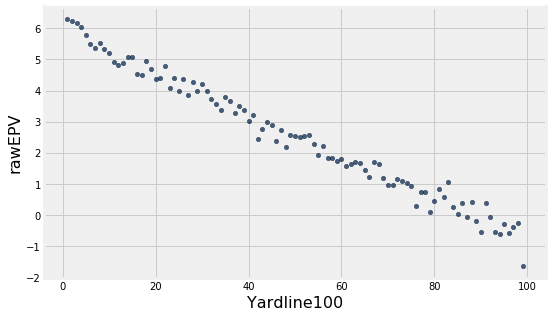

In [8]:
epv.scatter('Yardline100', select='rawEPV', height=5, width=8)

### C. Smoothed Expected Possession Value Model


#### Model Smoothing

Suppose we have data that is noisy but we know the underlying model should be smooth.  We can do some basic curve fitting, or _smoothing_, to clean up the data and give us something nice.  The next cell shows a simple example of this using the provided function `curve_fit`.  The parameter `smoothness` controls how smooth the output is.  Feel free to vary the parameter to see how the output changes.

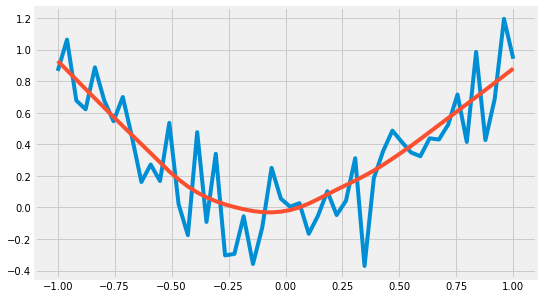

In [9]:
x = np.linspace(-1, 1)
y = x**2 + .2 * np.random.randn(len(x)) # y is a noisy parabola

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y);

y_smooth = curve_fit(x, y, smoothness=.5)
ax.plot(x, y_smooth);

#### Smoothing Expected Possession Value

We can now use the curve fitting to produce a "smoothed" estimate of the Expected Possession Value.

After this, `epv_model` contains our model for Expected Possession Value for a location on the field.

In [10]:
yardlines = epv['Yardline100']
poss_vals = epv['rawEPV']

# create the smoothed EPV values using a custom smoothness value
epv_values = curve_fit(yardlines, poss_vals, smoothness=.22)
# create the EPV model
epv['EPV'] = epv_values

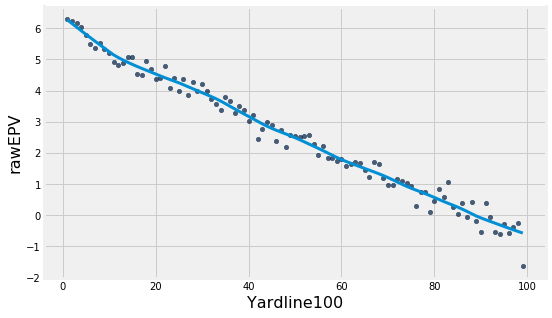

In [11]:
# fig, ax =  plt.subplots(figsize=(8, 5))
epv.scatter('Yardline100', select='rawEPV', height=5, width=8)

ax = plt.gca()
ax.plot(epv['Yardline100'], epv['EPV'], lw=3);

#### Make the Model

To make the model useable, we need to convert it to a dictionary.  The next cell shows how this is done.

In [12]:
def make_model(keys, values):
    model = {key: val for key, val in zip(keys, values)}
    return model

epv_model = make_model(epv['Yardline100'], epv['EPV'])

**Questions**

1. Around the 10 yard line (90 in Yardline100), the expected value is 0.  What does this mean?
2. What is the significance of the slope of the line?  What are its units?
3. There appears to be an elbow in the curve around the opponent 10 yard line (10 in Yardline100).  This is where first downs go from 10 yards to go to goal to go.  Can you provide a possible reason for this increase in the rate of EPV?
4. Consider two hypothetical alternative models for expected point:
    + The line goes from left to right from +6 to +5 (much less steep than the actual model).  
    + The line goes from +6 to -6 and passes 0 at the 50 yard line (much steeper than the actual model).
   
   What would you conclude about possession and scoring in these two hypothetical situations?

**Answers**

1. It's the breakeven point where scoring for the possessing team and the defending team are in balance.  Any further away from the goal and the spot would have positive expected value for the defense.
2. The slope quantifies the expected points gained per yard.
3. All things being equal, if one first down opportunity is closer to the goal than another first down opportunity, then the first opportunity will have a higher expected value.  However, as one gets closer to the goal, the first downs get shorter: 1st and goal at the 3 requires fewer yards than 1st and goal at the 9.  It could be that there's a combined effect going on here.  The expected value increases as you get closer and it increases as the length of the first down shortens.
4. In the first scenario, scoring would be incredibly high.  If you get the ball, it's likely you'll score a touchdown.  In the second scenario, scoring is directly related to how close the ball is to each goal.  The game is more of a seesaw and field position is far more important.

## Model 2: Net Punt Distance

We need net punt distance.  Extracting punts from the full play-by-play is easy (there's a playtype flag).  Determining net punt distance is tricky.  A few things can happen on a punt: 
+ It goes off as expected
+ Returned for a touchdown
+ Muffed
+ Fumbled
+ Blocked.  

There may be even more wrinkles.  Suffice to say, this is a bit complicated.  To simplify things, we just want to know the expected net punt distance for punts that are not returned, muffed, fumbled, blocked, or anything else.  

We compute net punt distance by finding regular punts and determining the field position change.

In [13]:
punts = Table.read_table('data/nfl_punts_2009_2016.csv', sep=',')
punts.show(10)

GameID,HomeTeam,AwayTeam,Drive,Half,Quarter,Down,PossessionTeam,Yardline100,YrdRegion,PlayType,NetPuntDist
2009091000,PIT,TEN,1,1,1,4,PIT,56,Beyond20,Punt,54
2009091000,PIT,TEN,2,1,1,4,TEN,96,Beyond20,Punt,39
2009091000,PIT,TEN,3,1,1,4,PIT,41,Beyond20,Punt,30
2009091000,PIT,TEN,5,1,1,4,PIT,79,Beyond20,Punt,53
2009091000,PIT,TEN,8,1,2,4,TEN,44,Beyond20,Punt,39
2009091000,PIT,TEN,9,1,2,4,PIT,62,Beyond20,Punt,35
2009091000,PIT,TEN,15,2,3,4,PIT,45,Beyond20,Punt,40
2009091000,PIT,TEN,16,2,3,4,TEN,96,Beyond20,Punt,50
2009091000,PIT,TEN,17,2,3,4,PIT,43,Beyond20,Punt,33
2009091000,PIT,TEN,18,2,3,4,TEN,71,Beyond20,Punt,56


**Question**

1. Why is it okay to simplify things?  To assist in reasoning out your response, it's helpful to know that in 2017 NFL teams averages 1 punt return TD per 100 punt return attempts.  The key question of whether it's okay to simplify things is this: By about how many points in expectation does ignoring punt return TDs change the result?

**Answer**

If there is 1 punt return TD per 100 punt return attempts, then by omitting those events, we overestimate the value of a punt.  By how much?  Around $.01 \times 7 = 0.07$, the value of the return TD times how frequently they occur.  This is such a small amount that it really won't change much about our results.  

### A. Net Punt Distance

To compute net punt distance, we consider all the "successful" punts we extracted (ie. ignoring return TDs, muffs, and fumbles, etc).  In building the punts table, we look at the current yardline and the next yardline and computed a difference (accounting for the switch in orientation of the 100 yard value) to get net punt distance.  Now we just need to average.

In the plot below, we see a beautiful relationship between expected punt distance and the yardline.  As with Expected Possession Value, the expected net punt distance should be increasing as you get closer and not fluctuating as much.

In [14]:
# 1. Group by yardline
# 2. Take the average of net_punt_len (the average automatically ignores null values!)
punt_dist = punts.select(['Yardline100', 'NetPuntDist']).\
    group('Yardline100', collect=np.mean).\
    relabel('NetPuntDist mean', 'rawNetPuntDist')
punt_dist

Yardline100,rawNetPuntDist
29,18.5
30,21
31,26
32,19.3636
33,17.8462
34,19.5833
35,22.5
36,25.575
37,25.3725
38,27.2267


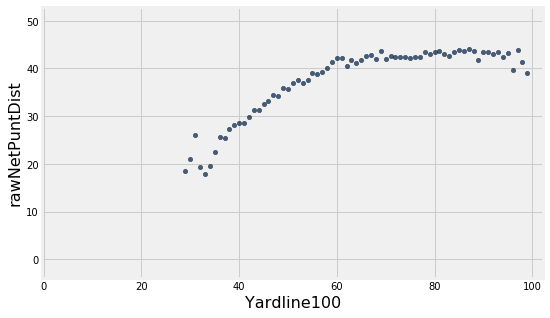

In [15]:
punt_dist.scatter('Yardline100', select='rawNetPuntDist', height=5, width=8)

ax = plt.gca()
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53);

### C. Smoothed Net Punt Distance

We can run our curve fit to generate a final model.  We clearly require this since we do not want a straight line for Expected Net Punt Distance.

`punt_dist_model` will contain our model for Expected Net Punt Distance.

In [16]:
yards = punt_dist['Yardline100']
raw_punt_dist = punt_dist['rawNetPuntDist']

# use the default smoothness parameter
xpunt_dist = curve_fit(yards, raw_punt_dist)

# Convert to integer values (this will be needed later)
xpunt_dist = np.round(xpunt_dist).astype(int)
punt_dist['NetPuntDist'] = xpunt_dist

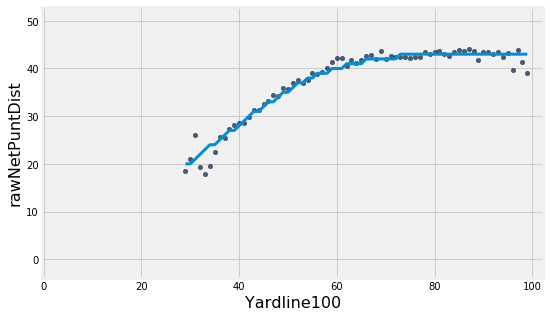

In [17]:
punt_dist.scatter('Yardline100', select='rawNetPuntDist', height=5, width=8)

ax = plt.gca()
ax.plot(punt_dist['Yardline100'], punt_dist['NetPuntDist'], lw=3)

ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53);

#### Make the Model

In [18]:
punt_dist_model = make_model(punt_dist['Yardline100'], punt_dist['NetPuntDist'])

**Question**
1. Without redoing everything, what is one way you could tweak the model to account for the quality of the punter or the quality of the punt coverage by the punting team?

**Answer**

We can can account for punting quality for regular punts (from 60 to 100) and for precision punts (~30 to 60).  If we have a punter with a strong leg who can kick the ball high in the air, we can push the segment of the curve from 60 to 100 higher to account for this ability.  And if we have a kicker with good distance control and aim, we can tilt the sloped segment from ~30 to 60 higher to account for this ability.

How much should we adjust by?  That's up to us to determine the quality of our punter.

## Model 3: 1st Down Conversion Probability


In football, teams typically treat third down as do or die.  Hence, we are going to use third down conversion percentage as a proxy for 4th down conversion percentage.  You shouldn't have a hard time convincing yourself why it make sense to approximate the conversion percentage using 3rd down data instead of 4th down data.

There are some things we need to address.  In the dataset, various non-relevant plays can occur on third down.  We need to ignore these.  Also, we can likely safely assume that beyond 9 yards we do not need to consider going for it.

In [19]:
third_downs = Table.read_table('data/nfl_third_downs_2009_2016.csv', sep=',')
third_downs.show(10)

GameID,HomeTeam,AwayTeam,Drive,Half,Quarter,Down,PossessionTeam,Yardline100,YrdRegion,YardstoGo,PlayType,1stDownConversion
2009091000,PIT,TEN,1,1,1,3,PIT,56,Beyond20,8,Pass,0
2009091000,PIT,TEN,2,1,1,3,TEN,94,Beyond20,6,Run,0
2009091000,PIT,TEN,3,1,1,3,PIT,22,Beyond20,2,Sack,0
2009091000,PIT,TEN,4,1,1,3,TEN,19,10to20,7,Pass,0
2009091000,PIT,TEN,5,1,1,3,PIT,70,Beyond20,7,Sack,0
2009091000,PIT,TEN,6,1,1,3,TEN,57,Beyond20,3,Pass,1
2009091000,PIT,TEN,7,1,1,3,PIT,76,Beyond20,7,Pass,1
2009091000,PIT,TEN,9,1,2,3,PIT,87,Beyond20,2,Pass,1
2009091000,PIT,TEN,9,1,2,3,PIT,62,Beyond20,5,Pass,0
2009091000,PIT,TEN,10,1,2,3,TEN,69,Beyond20,6,Pass,1


### A. Expected Conversion Percentage

#### Conversion Percentage by Region

We each separate region on the field (inside the 10 yardline, from the 10 yardline to the 20 yardline, and beyond the 20 yardline), and compute the expected conversion percentage for each yard to go value.  We separate into regions because we have reason to believe that near the goalline, the offense is less likely to convert given less room to work with.  The data bears this out.  This change in conversion percentage can affect the expected value quantities.

As with possession value, we need to smooth out the values since they should be consistent as the yards change incrementally.

In [20]:
# 1. Group by region and yards to go
# 2. Take the average success rate
conv_pct = third_downs.\
    select('YrdRegion', 'YardstoGo', '1stDownConversion').\
    groups(['YrdRegion', 'YardstoGo'], collect=np.mean).\
    relabel('1stDownConversion mean', 'rawConvPct')

# pivot to a better table form
conv_pct = conv_pct.pivot('YrdRegion', 'YardstoGo', values='rawConvPct', collect=np.mean)
conv_pct

YardstoGo,10to20,Beyond20,Inside10
1,0.669565,0.694705,0.604803
2,0.580381,0.59172,0.491979
3,0.494595,0.547519,0.454737
4,0.471545,0.518423,0.375262
5,0.417344,0.494278,0.42093
6,0.44709,0.448335,0.311864
7,0.391534,0.433759,0.375
8,0.310924,0.407245,0.347059
9,0.271186,0.354182,0.254237


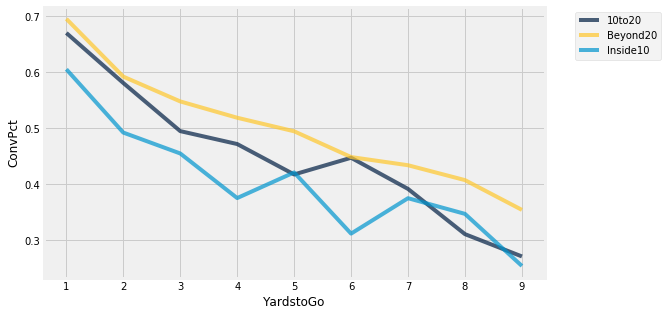

In [21]:
conv_pct.plot('YardstoGo', height=5, width=8)

ax = plt.gca()
ax.set_xlabel('YardstoGo')
ax.set_ylabel('ConvPct');

### B. Smoothed Expected Conversion Percentage

We'll use the curve fitting again to smooth out our Expected Conversion Percentage.

Our final model for Expected Conversion Percentage will be in `conv_pct_model`.

In [22]:
conv_pct_smooth = conv_pct.copy()
yards_to_go = conv_pct_smooth['YardstoGo']

# Create the smoothed model for each region of the field
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region = conv_pct[region]
    # use the default smoothness parameter
    fitted_vals = curve_fit(yards_to_go, conv_pct_region)
    conv_pct_smooth[region] = fitted_vals

conv_pct_smooth

YardstoGo,10to20,Beyond20,Inside10
1,0.669242,0.693211,0.596
2,0.581219,0.618611,0.514026
3,0.516413,0.549239,0.443121
4,0.465592,0.5198,0.411455
5,0.444032,0.488122,0.37705
6,0.417466,0.458036,0.36519
7,0.386733,0.430625,0.35046
8,0.323368,0.399153,0.328476
9,0.26672,0.357095,0.261702


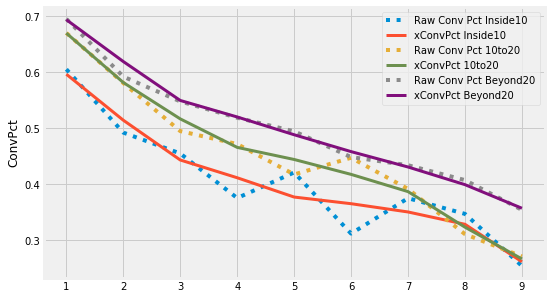

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

for region in ['Inside10', '10to20', 'Beyond20']:
    # plot the raw conversion percentage
    ax.plot(yards_to_go, conv_pct[region], ls=':', label='Raw Conv Pct ' + region)
    
    # plot the model conversion percentage
    ax.plot(yards_to_go, conv_pct_smooth[region], lw=3, label='xConvPct ' + region)

ax.legend(loc=1)
ax.set_ylabel('ConvPct');

In [24]:
# Build the model for later use
conv_pct_model = {}
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_model[region] = make_model(conv_pct_smooth['YardstoGo'], conv_pct_smooth[region])
    
conv_pct_model

{'Inside10': {1: 0.5960003678430112,
  2: 0.5140258673061313,
  3: 0.4431209206499419,
  4: 0.41145480086447467,
  5: 0.3770499308877335,
  6: 0.36518972719825615,
  7: 0.3504596141270803,
  8: 0.3284761666652096,
  9: 0.26170181111277924},
 '10to20': {1: 0.6692423105995751,
  2: 0.5812192183729629,
  3: 0.5164133187606074,
  4: 0.4655915087253356,
  5: 0.4440321365770252,
  6: 0.4174659235728865,
  7: 0.3867331716202912,
  8: 0.32336762297150146,
  9: 0.2667198834804571},
 'Beyond20': {1: 0.6932108558355317,
  2: 0.6186107180041114,
  3: 0.5492393577550316,
  4: 0.5197998906431245,
  5: 0.4881219036257838,
  6: 0.4580357541823809,
  7: 0.4306249995048785,
  8: 0.3991532916419553,
  9: 0.3570952388023575}}

**Questions**

1. What is the likely reason that it makes a difference in conversion percentage where on the field the ball is?  For example, do you think it is easier or harder to convert a third down at your own 30 yard line versus at your opponent's 7 yard line?
2. The change in conversion percentage is about 10 percentage points between the middle of the field and inside the 10 yard line.  Can you quantify in points how meaningful those 10 percentage points are?

**Answers**

1. As you get closer to the goalline, the amount of field to work with shrinks.  The intuition is that it becomes more difficult to convert as the field shrinks.
2. Suppose it's 4th and 1 at the 50 yard line.  In the middle of the field, the probability of conversion is .7. The expected value of trying for the conversion is approximately $0.7 \times 2.5 + 0.3 \times -2.5 = 1.0$.  If the conversion percentage drops to 60%, the change in expected points is about .5 points: $0.6 \times 2.5 + 0.4 \times -2.5 = 0.5$.  The drop in expected value due to the reduced conversion probability increases closer to the goal.

## Model 4: Field Goal Probability

We gather field goal results and compute the expected probability of success.

Raw field goal probability is a bit noisy as we have grown accustom to seeing so far.  We fit a curve but this time we ignore data observations beyond 63 yards since they are extra noisy.

### Field Goals

For field goal results, we just need FieldGoalDistance and FieldGoalResult and then to compute a 0-1 value representing the success.  This is straightforward.

In [25]:
fgs = Table.read_table('data/nfl_fgs_2009_2016.csv', sep=',')
fgs.show(10)

FieldGoalDistance,FieldGoalResult,FieldGoalSuccess
37,No Good,0
31,Blocked,0
45,Good,1
32,Good,1
33,Good,1
37,Good,1
21,Good,1
20,Good,1
37,Good,1
47,Good,1


### A. Field Goal Probability

In [26]:
# 1. Group by distance 
# 2. Take the average success rate
fg_prob = fgs.\
    select('FieldGoalDistance', 'FieldGoalSuccess').\
    group('FieldGoalDistance', collect=np.mean).\
    relabel('FieldGoalSuccess mean', 'rawFieldGoalProb')

fg_prob = fg_prob.where('FieldGoalDistance', are.below_or_equal_to(63))
fg_prob

FieldGoalDistance,rawFieldGoalProb
18,1
19,1
20,0.994253
21,0.96988
22,0.977679
23,0.982609
24,0.934426
25,0.99061
26,0.961957
27,0.972222


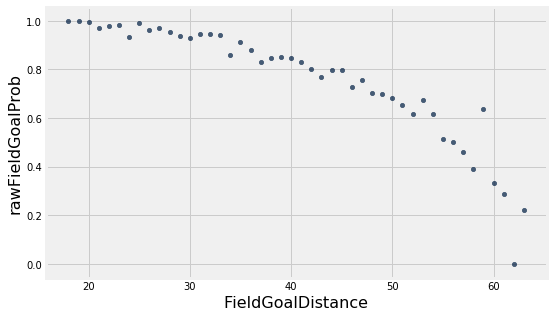

In [27]:
fg_prob.scatter('FieldGoalDistance', select='rawFieldGoalProb', height=5, width=8)

### B. Smoothed Field Goal Probability

We can run another curve fit to get a nice estimate of field goal probability.

`fg_prob_model` will contain our field goal probability model.

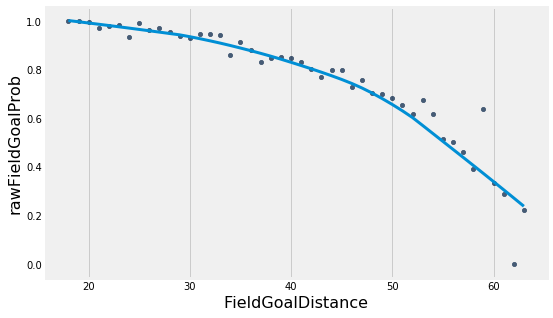

In [28]:
fg_dist = fg_prob['FieldGoalDistance']
raw_fg_prob_values = fg_prob['rawFieldGoalProb']

# use the default smoothness parameter
fg_prob_values = curve_fit(fg_dist, raw_fg_prob_values)
# build the FG model
fg_prob['FieldGoalProb'] = fg_prob_values

fg_prob.scatter('FieldGoalDistance', select='rawFieldGoalProb', height=5, width=8)
ax = plt.gca()
plt.plot(fg_prob['FieldGoalDistance'], fg_prob['FieldGoalProb'], lw=3)
ax.grid(axis='y')

#### Make the Model

In [29]:
fg_prob_model = make_model(fg_prob['FieldGoalDistance'], fg_prob['FieldGoalProb'])

**Question**

1. We are computing a baseline "average" model that can be used as a starting point.  Obviously the quality of the kicker and the field/weather conditions are incredibly important to kicking.  How would you adjust our model to account for these considerations?

**Answer**

For the quality of the kicker, we'd want to tilt the curve up or down, especially at the tail for distances above 50.  In wind, we can shift the curve left or right, imagining that the there's a wind-adjusted distance that gives the distance the ball must travel without wind.

## Decision Making

Let's put the models to work

### Extracting Model Values

First, let's show how we can extract outputs from the model based on a hypothetical situation.

It's 4th and 4 from the opponent's 42 yard line (this means `Yardline100` is 42).  What are the model outputs?

In [30]:
yardline100 = 42
region = 'Beyond20'
yrdstogo = 4
fg_distance = yardline100 + 17

# Model values can be extracted easily
print(f"EPV at opponent 42 yardline: {epv_model[yardline100]:.2f}")
print(f"Exp Conv Pct beyond the 20 with 4 yards to go: {conv_pct_model[region][yrdstogo]:.2f}")
print(f"Exp Net Punt Dist from the 42: {punt_dist_model[yardline100]:.2f}")
print(f"Exp FG Pct from 45 yards: {fg_prob_model[fg_distance]:.2f}")

EPV at opponent 42 yardline: 3.01
Exp Conv Pct beyond the 20 with 4 yards to go: 0.52
Exp Net Punt Dist from the 42: 30.00
Exp FG Pct from 45 yards: 0.37


#### TO DO: Another Model Value Example

It's 4th and 1 from the opponent's 2 yard line.  What are the model outputs?  Note: Is the punt model valid here?

In [31]:
yardline100 = 2
region = 'Inside10'
ydstogo = 1
fg_distance = yardline100 + 17

print(f"EPV at opponent 42 yardline: {epv_model[yardline100]:.2f}")
print(f"Exp Conv Pct beyond the 20 with 4 yards to go: {conv_pct_model[region][ydstogo]:.2f}")
print(f"Exp FG Pct from 45 yards: {fg_prob_model[fg_distance]:.2f}")

EPV at opponent 42 yardline: 6.16
Exp Conv Pct beyond the 20 with 4 yards to go: 0.60
Exp FG Pct from 45 yards: 1.00


### Expected Value of our Decisions

It's 4th and 1 from the opponent's 35 yard line.  What should we do?

In [32]:
yardline100 = 35
region = 'Beyond20'
yrdstogo = 1
fg_distance = yardline100 + 17

#### TO DO: Expected value of going for it
1. First determine the value of a successful conversion.  Here are the rules for determining this value:
    + If the situation **is not** goal to go,  get the EPV of the yardline at the spot of the conversion.  Assume the down is converted with the smalled possible number of yards, ie. the yards to go.  So if it's 4th and 4 at the 42, the first down as at the 38.
    + If the situation **is** goal to go, then a 1st down conversion is a TD so take 7 minus the value of a kickoff.
2. Then determine the value of a failed conversion
    + Assume the conversion fails at the current yardline (not yards gained or lost on the failure).
    + Find the starting yardline for the opposing team by taking 100 minus the current yardline
    + Get the EPV for this starting position and multiply by -1 to get the value for _our team_ and not the opposing team.
3. Finally, compute the expected value using the conversion success probability
    + Weight the above expected values by the conversion success probability based on the region of the field

In [33]:
conv_line = yardline100 - ydstogo
ev_success = epv_model[conv_line]

fail_line = 100 - yardline100
ev_failure = -epv_model[fail_line]

p_conv_success = conv_pct_model[region][ydstogo]

ev_goforit = p_conv_success * ev_success + (1 - p_conv_success) * ev_failure
ev_goforit  # 2.0800749018024116

2.0800749018024116

#### TO DO:  Expected value of punting
1. Determine the expected net punt distance from the model.
2. Compute the expected value of the expected yardline after the punt
    + The expected yardline following the punt is the current yardline minus the expected punt distance.  So if we're at our own 30 yardline (Yardline100 = 70) and the punt distance is 42 yards, the expected yardline is 28.
    + Find the starting yardline for the opposing team by taking 100 minus the expected yardline after the punt
    + Get the EPV for the expected starting position and multiply by -1 to get the value for our team.

In [34]:
xpunt_dist = punt_dist_model[yardline100]
xyardline = yardline100 - xpunt_dist
opp_start_line = 100 - xyardline

ev_punt = -epv_model[opp_start_line]
ev_punt  # 0.03172564552047145

0.03172564552047145

#### TO DO:  Expected value of kicking
1. Compute the value of making the field goal: 3 minus the value of a kickoff, which is given by `ekv`.
2. Compute the value of missing the field goal.
    + Missing the kick means the ball is turned over at Yardline100 + 7
    + The starting position for the opposing team is 100 minus (Yardline100 + 7)
    + Get the EPV for the starting position
3. Compute the expected value using the field goal success probability
    + The kick distance is given by Yardline100 + 17
    + Use the kick distance to get the field goal success probability
    + Weight the two values in 1. and 2. by the field goal success probability

In [35]:
ev_fg_success = 3 - ekv

fg_yardline = yardline100 + 7
opp_start_line = 100 - fg_yardline
ev_fg_failure = -epv_model[opp_start_line]

fg_distance = yardline100 + 17
p_fg_success = fg_prob_model[fg_distance]

ev_fg = p_fg_success * ev_fg_success + (1 - p_fg_success) * ev_fg_failure
ev_fg  # 0.680632357737473 

0.680632357737473

#### Decision

We can print out the three expected values. 

You should get this:
```
EV going for it: 2.08
EV punting:      0.03
EV field goal:   0.68
```

In [36]:
print(f"EV going for it: {ev_goforit:.2f}")
print(f"EV punting:      {ev_punt:.2f}")
print(f"EV field goal:   {ev_fg:.2f}")

EV going for it: 2.08
EV punting:      0.03
EV field goal:   0.68


**Questions**

1. Which choice would you make?  Why?  What else would go into your decision?
2. How much extra is the decision worth in expected points?

**Answers**

I would go for it.  Going for it is worth about 1.4 extra points in expectation.  That's a pretty big gap.

## Visualizing Decisions

We can use a helper function which iterates over all the yardline and yards-to-go combinations to compute the decisions.

The function computes the following:
+ The best choice 
+ The expected value of the best choice
+ The second best choice
+ The _difference_ in expected value of the best choice over the second best choice

In [37]:
data = compute_4thdownbot_data(
    ekv, epv_model, conv_pct_model, punt_dist_model, fg_prob_model)

yardline100 = 20
yrdstogo = 5
print(data[yrdstogo][yardline100])

{'decision': 'go for it', 'ev': 2.075357194472135, 'second_choice': 'kick', 'ev_over_second': 0.12731185997036554}


### 4th Down Bot Decisions

We use a helper function to visualize the decision space.

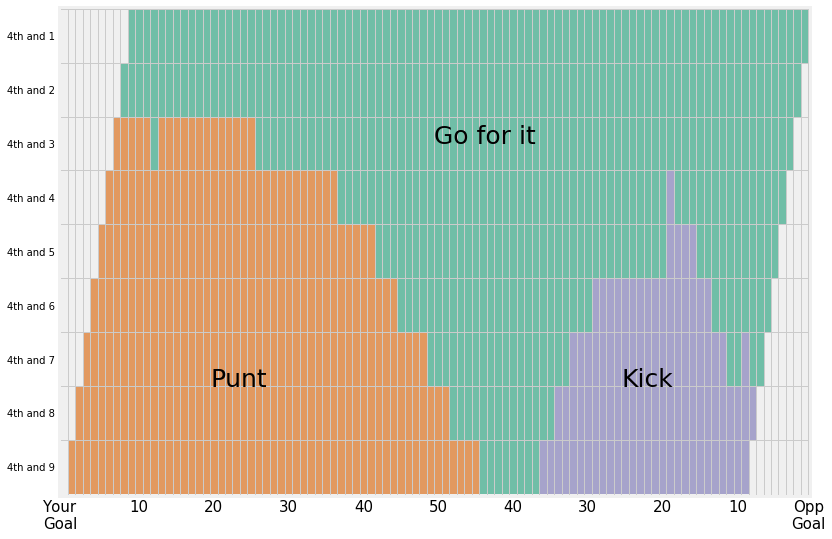

In [38]:
plot_4thdown_decision(data)

**Question**
1. If we just show the best decision choices, what are we missing in terms of information?  What else would you want to know regarding making any decisions?

**Answer**

This plot doesn't show us how much of an improvement in expected points each decision is worth.

### Second Choices

We can also look at the second best choices.

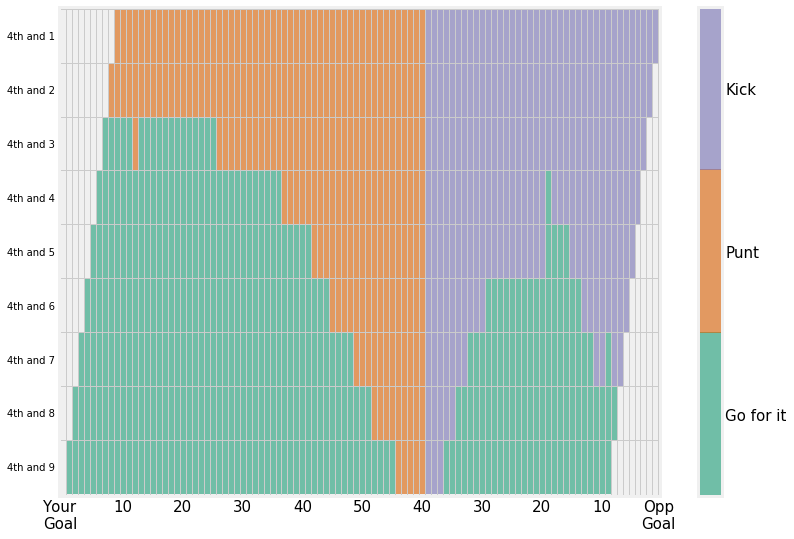

In [39]:
plot_4thdown_second_choices(data)

**Question**
1. What appears to happen around the 37-38 yard line with respect to punting and kicking a field goal?

**Answer**

At that yard line, the punt doesn't provide much of a net distance gain.  The probability of making a field goal also is high enough to make the kick more valuable than the field position gain of a punt.

### Expected Values

It would be useful to know how many points we expect when making our decision.

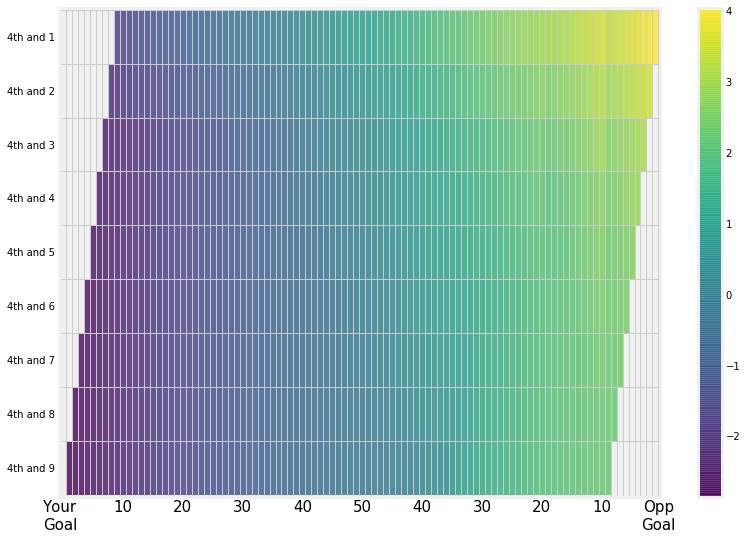

In [40]:
plot_4thdown_evs(data)

### Expected Value over Second Choice

Even more useful would be to know how many more points our top choice is worth relative to the next best choice.

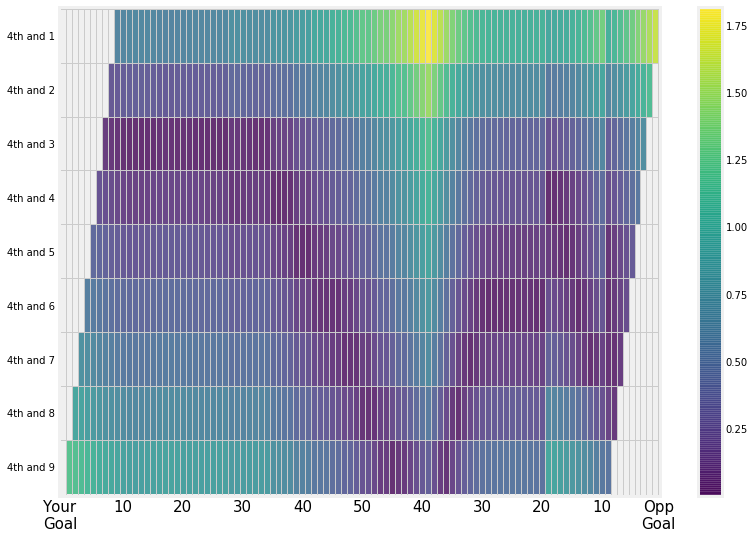

In [41]:
plot_4thdown_ev_over_second(data)

**Questions**
1. What is the significance of the bright yellow region around the 38 yard line?  What is it telling us about punting or kicking a field goal relative to trying to hold onto possession?
2. There is a huge region over which the 4th Down Bot says to go for it.  Does the increase in expected value from going for it seem particularly large over most of that region?

**Answers**

1. The bright yellow region indicates that going for it there is worth considerably more than the second best choice.
2. For a lot of the region where the model recommends going for it, there is a relatively small gain (< .5 points) from doing so.

### Coaches' Choices

![coaches_decisions](coach_decisions.png "Coaches Decisions")

Compare the 4th Down Bot's decisions with the actual coaches decisions (courtesy of the NYT).  

**Question**
1. How does the previous plot showing the expected value over the second choice compare to the coaches' choices?

**Answer**

It looks like coaches go for it when the gain in expected points is past a certain threshold, which I think looks to be about 1 point.

## Wrap Up

This notebook went over step by step how to piece together components using historical NFL play-by-play data to build a decision making 4th Down Bot.  The expected value analysis is very useful for beginning to think in a data-driven way.  Wrapping up, we finish with some general questions about expected value analysis and some considerations we might want to make.

In finance, there is a concept called _risk premium_ which refers to how much more return we demand for taking a riskier stock compared to a less risky stock.  That is, just because an stock has higher return, we will not necessarily take it due to the potential increase in risk.

Here's a simple example:  consider a game show where you may choose one of two doors which are hiding $\$$1,000 and $\$$0. Suppose I offer you $\$$500 instead of choosing a door.  Would you take the $\$$500 or choose a door?

The risk in this situation is the uncertainty of the payout and the possibility of ending up with $\$$0.  If you are unconcerned with risk, you view those options as equivalent.  If you are risk averse, you will opt for the $\$$500.  And if you are risk loving (ie. you derive benefit or utility or joy or something from taking risk) you will gamble on a door.

There is an amount called the _certainty equivalent_ where you would view that amount as equal to the gamble.  Since the expected value of the gamble is $\$$500, if you are risk averse the certainty equivalent is less than $\$$500.  It is the point at which below that amount you'd prefer the gamble and above that amount you'd prefer the certain payout.  Each person will have their own certainty equivalent.

The difference between the certainty equivalent and the expected value of the gamble is the risk premium.

The game show Deal or No Deal is an example of offering certainty amounts against gambles on large payouts.

**Questions**
1. How does punting represent a "certain" choice (or at least a less risky choice)?  
2. How does maximizing expected value ignore the risk in the decision?
   
   Consider this situation: we're on our own 10 yard line and its 4th and short.
   Some numbers for 4th and 1 from your own 10 yard line:
    + The expected value after conversion is about -0.09 points
    + The expected value after a failed conversion is -5.25 points
    + The conversion percentage is 69% so the overall expected value of going for it is -1.6
    + The expected value from punting is -2.3, .7 points lower than going for it.
   
   Overall, the EV for going for it is better.  But the downside of the failed conversion is high.  Is going for it a very risky decision based on those numbers?
   
4. Does maximizing expected points make sense throughout the game?  What about at the end of the game?


_Win Probability_

One possible alternative is to build a model for win probability given a game state.  The new NYT 4th Down Bot model does just this.  Using the win probability computation, a coach would make decisions that maximize win probability instead.  We saw something like this for bunting and stolen bases. 

Think of the classic Belichick choice against the Colts: go for it on 4th and short in your own territory at the end. [See here](https://fifthdown.blogs.nytimes.com/2009/11/16/defending-belichicks-fourth-down-decision/)

Here are some toy numbers.  Say it's 50-50 whether you make the conversion.  If you do make the conversion, you get a 100% win probability.  If you don't, you turn it over to Peyton Manning in his prime and now have a 20% win probability.  If you punt, you give the ball to Manning and its 60-40 in your favor.  Overall you have 60% win probability in each case.  
    
5. Does risk aversion still play a role when thinking about win probability?

_Ambiguity Aversion_

Risk averse people don't want to take risky bets even if they know the odds.  _Ambuigity averse_ people don't want to take bets they don't know the odds to  ([See here for an overview of ambiguity aversion](https://en.wikipedia.org/wiki/Ambiguity_aversion)).

So far, we've been quoting static numbers from models to build all our decisions.  We haven't pinned down how reliable or uncertain our models are.  

Let's reconsider Belichick's dilemma from 5.  We made up some numbers but they're not far off numbers other people have suggested.  So let's take our numbers as the output of the models.  An important question is how sure can we be these numbers are correct?  If the numbers aren't correct, do we want to take the gamble of going for it?  If we feel there is a lot of uncertainty in the model's output, we might be averse to this ambiguity and avoid taking the gamble.

6. How might a coach's decisions stem from both risk aversion and ambiguity aversion?
    
**Answers**

1. Punting is the safe play in that the risk of a catastrophic outcome (blocked punt, return TD, etc) is quite low and can be reasonably well controlled for, ie. you can use extra blockers to prevent a block.
2. If we just look at expected value, it appears clear to choose to go for it.  But the spread in the potential outcomes is over 5 points.  This is an incredibly risky decision: we can keep the ball and have it around the breakeven point, or we can give it to the other team and almost guarantee them a touchdown.  Expected value is fundamentally a summary of a decision that tells us nothing about the risk of the decision.
3. No.  It makes sense for a large portion of the game.  Near the end of the 1st half, if we factor in a time component, we would still want to maximize points.  At the end of the game though, we shouldn't be thinking about maximizing our points but maximizing our probability of winning.
4. No.  If all these probabilities are correct (see the next question regarding this assumption), then these two outcomes are equivalent: they both are equivalent to a weighted coin flip with a 60% chance of coming up in our favor.  And if we only care about winning, then risk plays no role because these two outcomes are equivalently risky.
5. Okay, so if we know all the probabilities exactly, ie. our models are perfect, then maximizing win probability eliminates our risk aversion issue.  However, we don't know the probabilities exactly.  I talked with Shachar Kariv (Chair of the Berkeley Econ department) about this and he pointed out something important to remember about probabilities, decision making, and ambiguity aversion: when in life do we ever have a situation where we know the true probability of the outcomes?  Basically never. 

    In the case of Belichick's dilemma, a coach is going to look at a decision to go for it wearily due to ambiguity aversion. But the probabilities associated with punting are also uncertain.  So overall there's a ton of ambiguity.  A coach opting to punt likely would be expressing a belief that the ambiguity associated with the punt is less.

    So how could risk aversion play a role in a coach's risk aversion?  Well, a simple thing could be that even accounting for the ambiguity, the punt is a relatively certain and safe decision compared to the risky gamble of going for it.  Of course, there's still the risk associated with what happens after the punt so you'd think they'd know that and not think of the punt as such a certainty.  But the funny thing about humans and decision making is a lot of times they don't think that far ahead!

    There's actually a related concept called _loss aversion_ that likely also plays a role.  Loss aversion comes from having relatively harsher views of negative outcomes compared to positive outcomes.  People frequently conjecture that coaches make decisions to avoid big negative outcomes.  An hypothetical example would be a coach who plays conservatively and loses 20-7 but never really had a chance at winning.  The coach didn't want to play aggressively and potentially lose by a big margin like 30 points.  If we just cared about winning, those two outcomes are equivalent.  But if we are averse to large losses, they cease to be equivalent.